In [1]:
from lppls import lppls
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime as dt
%matplotlib inline

In [2]:
# Download S&P 500 historical data
data = yf.download('LANNA.BK', start='2024-05-01', progress=False)

In [3]:
# convert time to ordinal
time = [pd.Timestamp.toordinal(t1) for t1 in data.index]

In [4]:
time[:10]

[739008,
 739009,
 739013,
 739014,
 739015,
 739016,
 739019,
 739020,
 739021,
 739022]

In [5]:
# create list of observation data
price = np.log(data['Adj Close'].values)

In [6]:
price[:10]

array([2.57413777, 2.57413777, 2.57413777, 2.57413777, 2.57413777,
       2.57413777, 2.57413777, 2.5883224 , 2.5883224 , 2.5883224 ])

In [7]:
# create observations array (expected format for LPPLS observations)
observations = np.array([time, price])

In [8]:
observations.shape

(2, 114)

In [9]:
from lppls import lppls_cmaes

In [10]:
lppls_model = lppls_cmaes.LPPLSCMAES(observations=observations)
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(max_iteration=3000, pop_size=4, factor_sigma=0.001)

(80_w,160)-aCMA-ES (mu_w=42.4,w_1=5%) in dimension 3 (seed=249916, Thu Oct 17 18:47:35 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    160 7.977987825573703e-02 1.0e+00 9.74e-01  7e-04  1e+03 0:03.5
    2    320 2.362639538023917e-02 2.2e+00 1.06e+00  7e-04  2e+03 0:03.6
    3    480 2.110578968304790e-02 4.7e+00 1.04e+00  8e-04  3e+03 0:03.6
   48   7680 2.003460508908613e-02 4.4e+03 8.63e+01  1e-07  1e-04 0:05.4


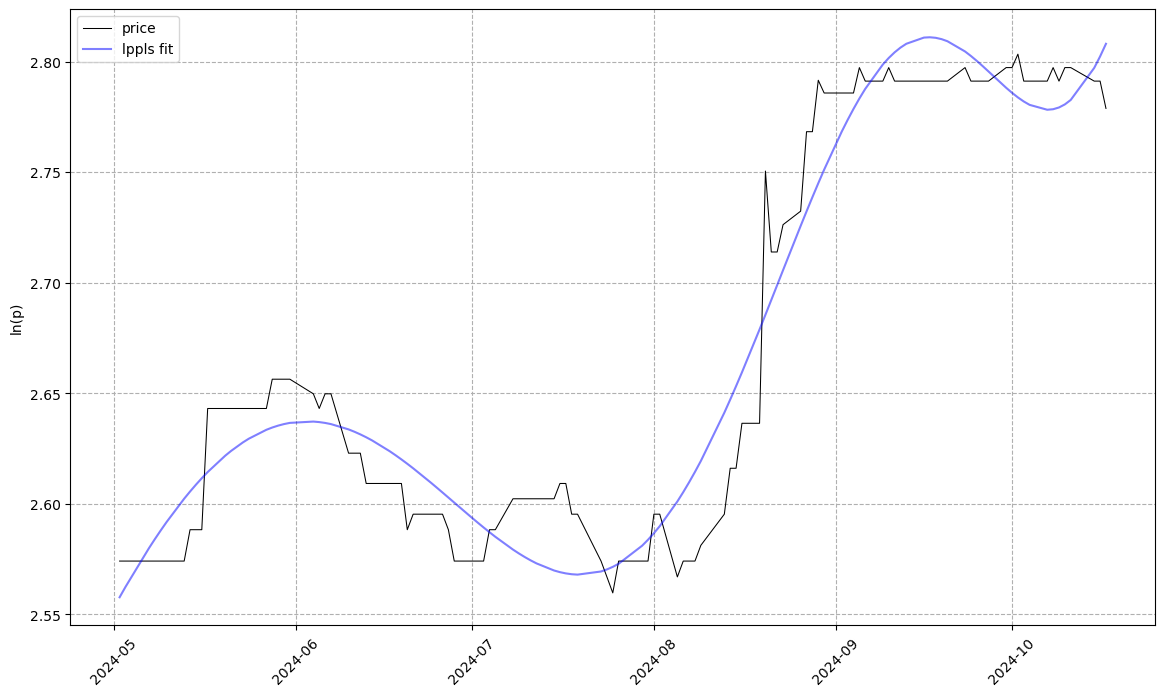

In [11]:
# visualize the fit
lppls_model.plot_fit()

In [12]:
pd.Timestamp.fromordinal(int(tc))

Timestamp('2024-12-07 00:00:00')

In [13]:
def lppl_predict(t, tc, m, w, a, b, c, c1, c2):
    return a + (b * (tc - t) ** m) * (1 + c1 * np.cos(w * np.log(tc - t)) + c2 * np.sin(w * np.log(tc - t)))

In [14]:
# Calculate predicted prices
predicted_values = lppl_predict(time, tc, m, w, a, b, c, c1, c2)

In [15]:
residuals = predicted_values - price

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
# Calculate Mean Squared Error
mse = mean_squared_error(price, predicted_values)
rmse = mse ** 0.5  # Root Mean Squared Error
r_squared = r2_score(price, predicted_values)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

MSE: 0.004396022788875393
RMSE: 0.06630250967252592
R-squared: 0.46488985910567693


In [18]:
current_price = price[-1]
potential_crash_magnitude = current_price - predicted_values[-1]

In [19]:
potential_crash_magnitude

-0.054328305158036994

In [20]:
# Output the potential crash magnitude
print(f"Current Price: {current_price}")
print(f"Last Predicted Value: {predicted_values[-1]}")
print(f"Potential Crash Magnitude: {potential_crash_magnitude}")

# Percentage crash magnitude
percentage_crash_magnitude = (potential_crash_magnitude / current_price) * 100
print(f"Potential Crash Magnitude (Percentage): {percentage_crash_magnitude:.2f}%")

Current Price: 2.778819295684189
Last Predicted Value: 2.833147600842226
Potential Crash Magnitude: -0.054328305158036994
Potential Crash Magnitude (Percentage): -1.96%
